# Milestone 2

Name : `Kamil Riyadi Alam Situmeang`

Batch : `FTDS009`

APP Url : https://kamil-tumor-detection-p2m2.herokuapp.com/

## I. Introduction

This project is meant for fulfilling `Hacktiv8 Fulltime Datascience Bootcamp Phase 2 - Milestone 2 assignment.`

### I.1 Project Background

In this project, I will try to implement `Convolutional Neural Network` in image classification task using `Tensorflow` library. The task that I choose is to distinguish people with `Brain Tumor` and `Normal` brain based on the x-ray images of their brain. 

Before start the project here is some information I cite from [mayoclinic.org](https://www.mayoclinic.org/diseases-conditions/brain-tumor/symptoms-causes/syc-20350084), regarding `Brain Tumor:`

> Many different types of brain tumors exist. Some brain tumors are noncancerous (benign), and some brain tumors are cancerous (malignant).

>How quickly a brain tumor grows can vary greatly. The growth rate as well as the location of a brain tumor determines how it will affect the function of your nervous system.

>Brain tumor treatment options depend on the type of brain tumor you have, as well as its size and location.

**Symptoms**

General signs and symptoms may include:

- New onset or change in pattern of headaches
- Headaches that gradually become more frequent and more severe
- Unexplained nausea or vomiting
- Vision problems, such as blurred vision, double vision or loss of peripheral vision
- Gradual loss of sensation or movement in an arm or a leg
- Difficulty with balance
- Speech difficulties
- Feeling very tired
- Confusion in everyday matters
- Difficulty making decisions
- Inability to follow simple commands
- Personality or behavior changes
- Seizures, especially in someone who doesn't have a history of seizures
- Hearing problems

**Causes**

Primary brain tumors originate in the brain itself or in tissues close to it. Primary brain tumors begin when normal cells develop changes (mutations) in their DNA. \
The mutations tell the cells to grow and divide rapidly and to continue living when healthy cells would die. The result is a mass of abnormal cells, which forms a tumor.

Based on information above, My aim in building image classification model is to help the doctor or medical team to justify wheter a patient has a brain tumor or not. Sooner the detection, the better medical treatment can be given to the patient.

### I.2 Dataset Description

**Content:**

This dataset consists of the images of brain x-rays of patient diagnosed of brain tumor.

**License**

[GNU General Public License, version 2](http://www.gnu.org/licenses/old-licenses/gpl-2.0.en.html)

### I.3 Objectives

The main objective of this project is:
- Create image classification classification model to distinguish person with brain tumor or normal brain.



## II. Import Libraries

In [1]:
# Import Libraries
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten

# Metric
from sklearn.metrics import classification_report, confusion_matrix

# Inference
from tensorflow.io import read_file
from tensorflow.image import decode_image, resize
from tensorflow import expand_dims
import requests
from PIL import Image
from io import BytesIO

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Enable Mixed Precision training for faster process (NVIDIA GPU Only)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


## III. Data Loading


In [3]:
# Creating dataframe by iterating through filepaths
dir_tumor=r'F:\Hacktiv8\FTDS009\Graded\Milestone\p2---ftds009---m2-KamilRiyadi\Brain Tumor Data Set\Brain Tumor Data Set\Brain Tumor'
dir_healthy=r'F:\Hacktiv8\FTDS009\Graded\Milestone\p2---ftds009---m2-KamilRiyadi\Brain Tumor Data Set\Brain Tumor Data Set\Healthy'

# Blank List
filepaths = []
filenames = []
labels= []
dict_list = [dir_tumor, dir_healthy]

# Loop
for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
      filenames.append(f)
      fpath=os.path.join(j,f)
      filepaths.append(fpath)
      if i==0:
        labels.append('Tumor')
      else:
        labels.append('Healthy') 


Filepath_series = pd.Series(filepaths, name="filepaths")
Filenames_series = pd.Series(filenames, name="filenames")
Label_series = pd.Series(labels, name="labels")

# Create Dataframe
main_data = pd.concat([Filepath_series, Filenames_series, Label_series], axis=1)
main_df = pd.DataFrame(main_data)

# Check
print(main_df["labels"].value_counts())
main_df.sample(5)

Tumor      2513
Healthy    2087
Name: labels, dtype: int64


filepaths  \
3288  F:\Hacktiv8\FTDS009\Graded\Milestone\p2---ftds...   
2471  F:\Hacktiv8\FTDS009\Graded\Milestone\p2---ftds...   
3060  F:\Hacktiv8\FTDS009\Graded\Milestone\p2---ftds...   
1111  F:\Hacktiv8\FTDS009\Graded\Milestone\p2---ftds...   
1825  F:\Hacktiv8\FTDS009\Graded\Milestone\p2---ftds...   

                   filenames   labels  
3288  Not Cancer  (1695).jpg  Healthy  
2471        Cancer (961).jpg    Tumor  
3060   Not Cancer  (149).jpg  Healthy  
1111       Cancer (1989).jpg    Tumor  
1825        Cancer (423).jpg    Tumor

In [4]:
# Images Metadata
metadata = pd.read_csv('metadata.csv')
metadata.drop(columns=['Unnamed: 0'], inplace=True)

## IV. Exploratory Data Analysis

In this process, I'll try to analyze my dataset and find some useful information.

In [5]:
# Check wheter there are duplicated images in the dataset
metadata.duplicated().sum()

0

Based from process above, I can say that there is no duplicated images inside the dataset. Now let's analyze the given metadata.

**Metadata Analysis**

In [6]:
# Images Metadata
metadata

image   class format mode          shape
0            Cancer (1).jpg   tumor   JPEG  RGB  (512, 512, 3)
1            Cancer (1).png   tumor    PNG    L     (300, 240)
2            Cancer (1).tif   tumor   TIFF  RGB  (256, 256, 3)
3           Cancer (10).jpg   tumor   JPEG  RGB  (512, 512, 3)
4           Cancer (10).tif   tumor   TIFF  RGB  (256, 256, 3)
...                     ...     ...    ...  ...            ...
4595  Not Cancer  (995).jpg  normal   JPEG  RGB  (168, 300, 3)
4596  Not Cancer  (996).jpg  normal   JPEG  RGB  (509, 452, 3)
4597  Not Cancer  (997).jpg  normal   JPEG  RGB  (197, 177, 3)
4598  Not Cancer  (998).jpg  normal   JPEG  RGB  (217, 232, 3)
4599  Not Cancer  (999).jpg  normal   JPEG  RGB  (221, 228, 3)

[4600 rows x 5 columns]

In [7]:
# Unique Values Check
categoricals = ['class', 'format', 'mode']
for i in categoricals:
    print(i)
    print(metadata[i].value_counts())
    print()

print('Count of unique shape :',metadata['shape'].nunique())

class
tumor     2513
normal    2087
Name: class, dtype: int64

format
JPEG    4496
TIFF      86
PNG       18
Name: format, dtype: int64

mode
RGB     4461
L        132
RGBA       5
P          2
Name: mode, dtype: int64

Count of unique shape : 475


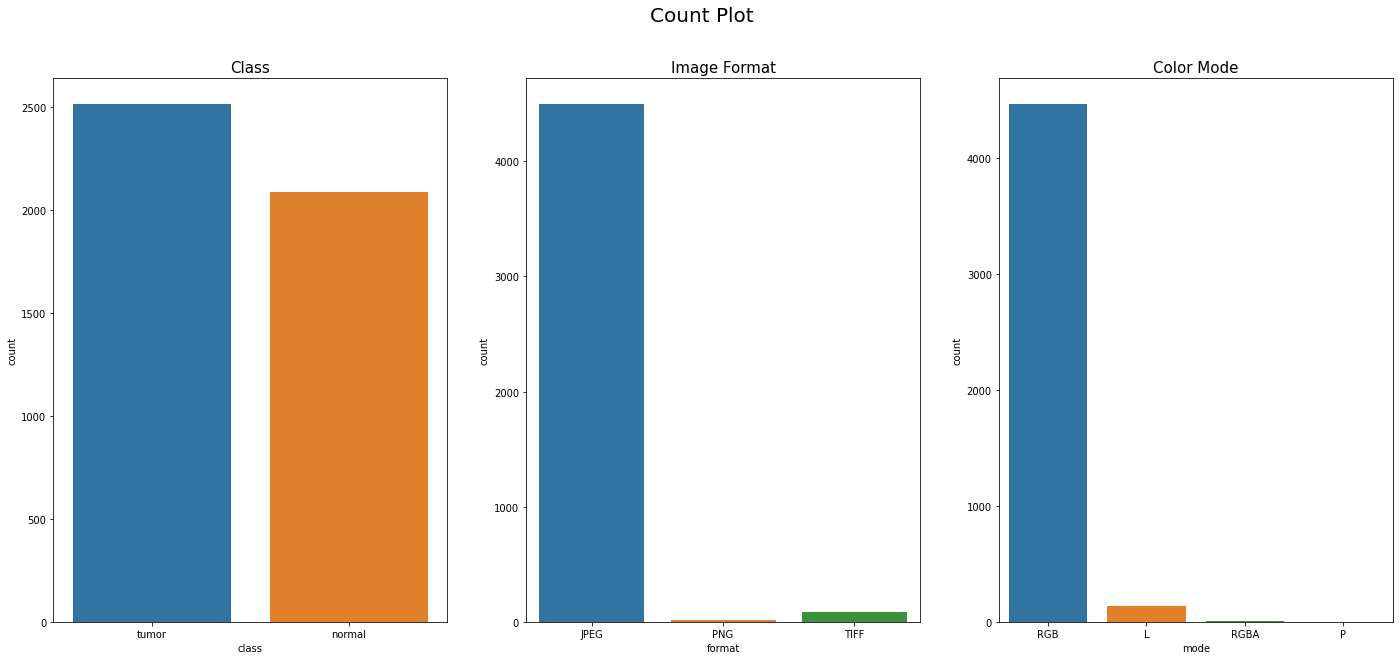

In [8]:
#  Metadata Visualization
fig, ax = plt.subplots(1,3, figsize=(24,10))
plt.suptitle('Count Plot', fontsize=20)
sns.countplot(x='class', data=metadata, ax=ax[0])
ax[0].set_title('Class', fontsize=15)

sns.countplot(x='format', data=metadata, ax=ax[1])
ax[1].set_title('Image Format', fontsize=15)

sns.countplot(x='mode', data=metadata, ax=ax[2])
ax[2].set_title('Color Mode', fontsize=15)

plt.show()

Based on process above, We can know that:
- There are 4600 images in the dataset, with 2513 instances of brain tumor and 2087 instances of normal brain. From the differences, I can tell that the instances is balanced between both class.
- There are 3 different images format in the dataset, with `4496` instances of `JPEG` format, `86` instances of `TIFF` format, and `18` instances of `PNG` format.
- There are 4 different images color mode in the dataset, with `4461` instances of `RGB` mode, `132` instances of `Cielab (L)` mode, `5` instances of `RGBA` mode, and `2` instances of `P` mode.
- The dataset consist of images with different `shape` and different `color mode`.

Now let's see the images in the dataset

**Image Sample**

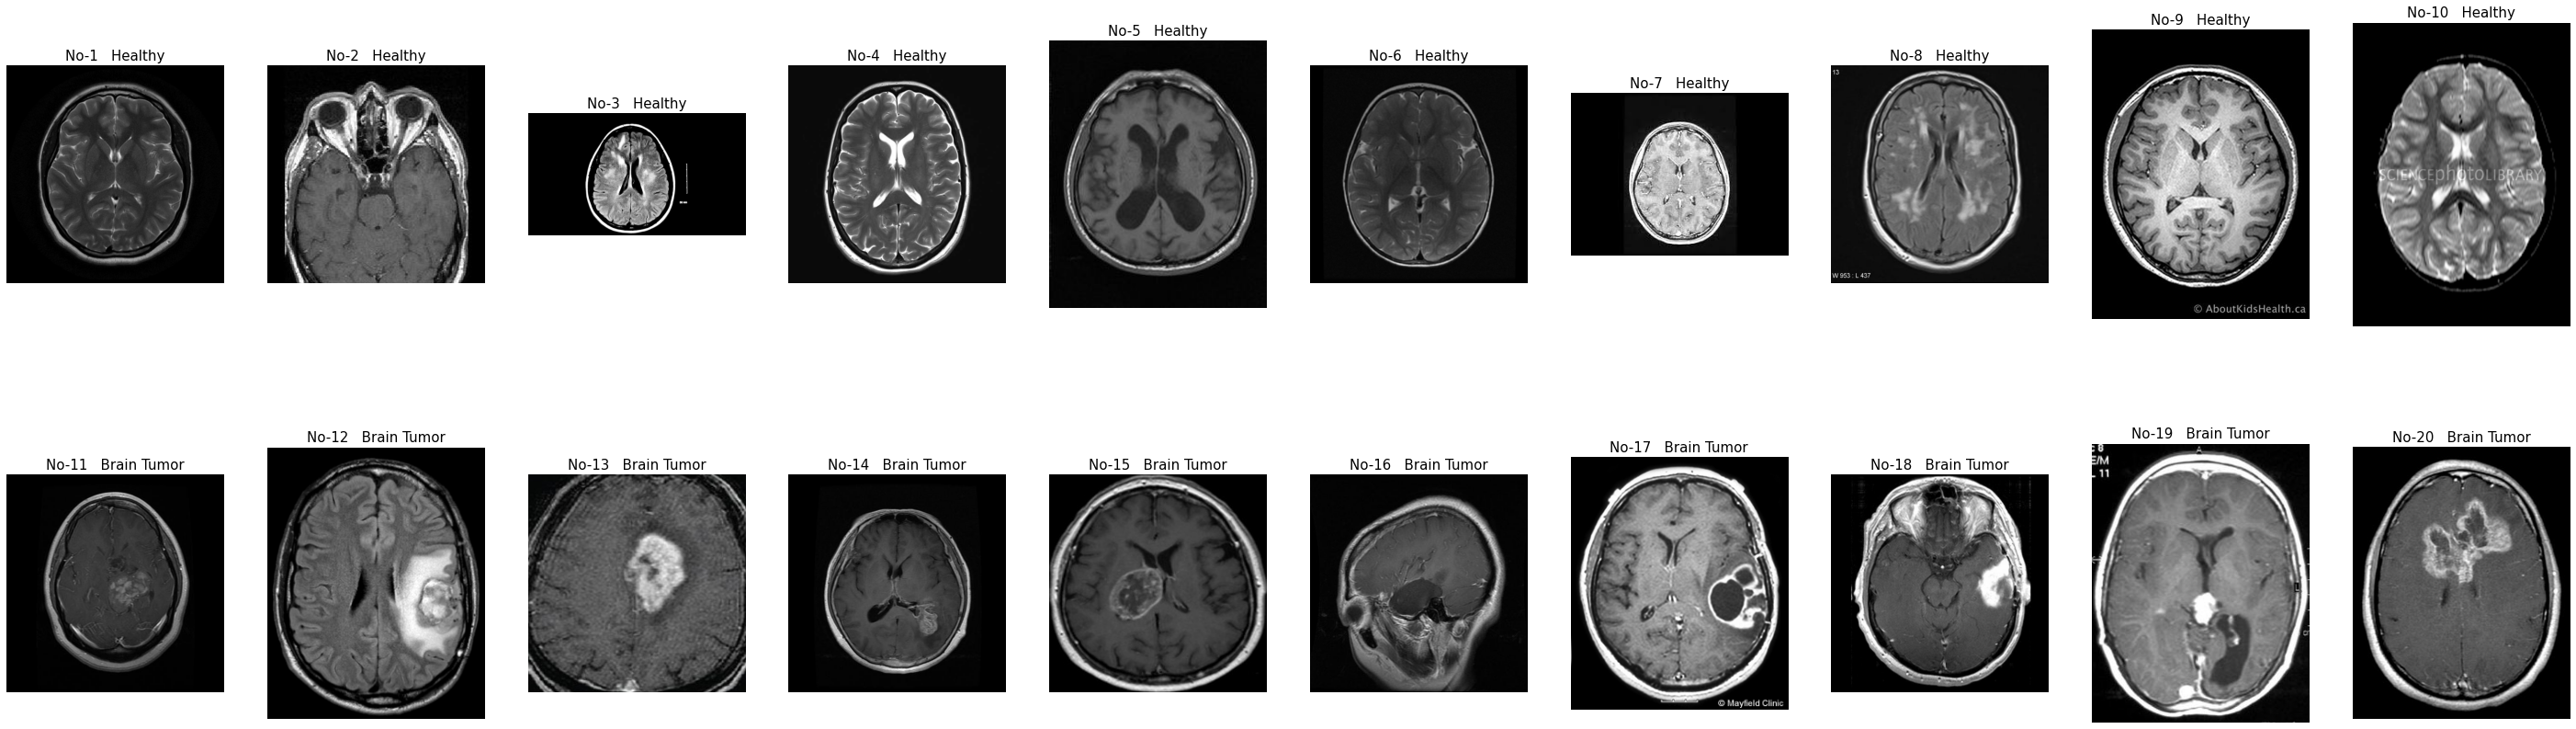

In [9]:
# Differentiate between healthy and tumor samples
healthy_samples = (main_df[main_df['labels']=="Healthy"]['filepaths'].iloc[:10]).tolist()
tumor_samples = (main_df[main_df['labels']=='Tumor']['filepaths'].iloc[:10]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(50,15)) # Set figure
    for i, sample in enumerate(samples):
        img = cv2.imread(sample) # read image
        ax[i//10, i%10].set_title('No' + '-' + str(i+1)+ "   " +sample.split('\\')[-2], size=15) # set image title
        ax[i//10, i%10].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # print image
        ax[i//10, i%10].set_axis_off() # turn off axis
    plt.show() # show overall images in the figure

# Execute the function
visualize_samples(healthy_samples + tumor_samples)

- From above process, I try to show 10 images of `Healthy` human brain and 10 images of human brain with `Tumor.`
- As we can see the X-ray images has `black and white` color. From instances above, all images was taken from above, giving us clear picture of human brain. We can easily distinguish between left or right part of the brain.
- From the result, We can see that human with `Tumor` in their brain can be identified by `round-shape like` object in their brain images. Those `round-shape like` object is shown by `brighter or darker color` than other `part of the brain`.

## V. Data Preprocessing


### Dataset Splitting

In this process, I will split my dataset into different set:

1. Use 80% from dataset for `Train Set`
2. Use 20% from dataset for `Test Set`
3. Use 20% from `Train Set` for `Validation Set`

all of those entries will be randomly selected from the dataset.


In [10]:
#Set Random State
random_state = 42

In [11]:
# Splitting Dataset

# Train-val Set & Test Set
train_val_images, test_images = train_test_split(main_df, test_size=0.2, random_state=random_state)

# Train Set & Val Set
train_images, val_images = train_test_split(train_val_images, test_size=0.2, random_state=random_state)

In [12]:
# Size Summary

print('Train Set shape : ', train_images.shape)
print('Val Set shape : ', val_images.shape)
print('Test Set shape : ', test_images.shape)

Train Set shape :  (2944, 3)
Val Set shape :  (736, 3)
Test Set shape :  (920, 3)


### Data Preprocessing

In this part of process, I will prepare my dataset so it can be fed into the model.\
I will do these folowing steps:

1. ImageDataGenerator:
- Rescale the images pixel values to be between 0 and 1.
- Apply augmentation to the images.
- Since the images used in this project are brain x-ray image (in which to take x-ray image must follow specific step / cannot haphazardly), I'll just apply `brightness_range and flip` for augmentation.
- I decide to set the output `dtype` as `float32.` (due to the image is rescaled between 0 and 1)

In [13]:
# Set Image Data Generator and Data Augmentation
image_gen = ImageDataGenerator(
    rescale = 1./255,
    brightness_range = (0.5,1.5),
    horizontal_flip=True,
    dtype='float32'
)

image_gen_ = ImageDataGenerator(
    rescale = 1./255,
    dtype='float32'
)

After that, I will make `data pipeline` using `flow_from_dataframe` function.

2. flow_from_dataframe:
- Set datafram `directory` and specify its `paths` and class `labels.`
- Set the `target_size` to 128x128, I deliberately choose 128x128 because size higher than that, takes much time to process in my machine.
- Set `color_mode` to `RGB` because we know that we have many different color modes (`RGB`, `Cielab (L)`, `RGBA`, `P`) and We just need one.
- Set `class_mode` to `binary` because we know that we have only two class (`Tumor` and `Healthy`).
- Set `batch_size` to `256`, No specific reason, I just want a higher number so the process could run faster.

this will return a `DirectoryIterator` yielding tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.

In [14]:
# Data Pipeline

train = image_gen.flow_from_dataframe(dataframe= train_images,x_col="filepaths",y_col="labels",
                                      target_size=(128,128),
                                      color_mode='rgb',
                                      class_mode="binary",
                                      batch_size=256,
                                      shuffle=True     
                                     )

val = image_gen_.flow_from_dataframe(dataframe= val_images,x_col="filepaths", y_col="labels",
                                    target_size=(128,128),
                                    color_mode= 'rgb',
                                    class_mode="binary",
                                    batch_size=256,
                                    shuffle=False
                                   )
                                   
test = image_gen_.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(128,128),
                                     color_mode='rgb',
                                     class_mode="binary",
                                     batch_size=256,
                                     shuffle=False
                                    )

Found 2944 validated image filenames belonging to 2 classes.
Found 736 validated image filenames belonging to 2 classes.
Found 920 validated image filenames belonging to 2 classes.


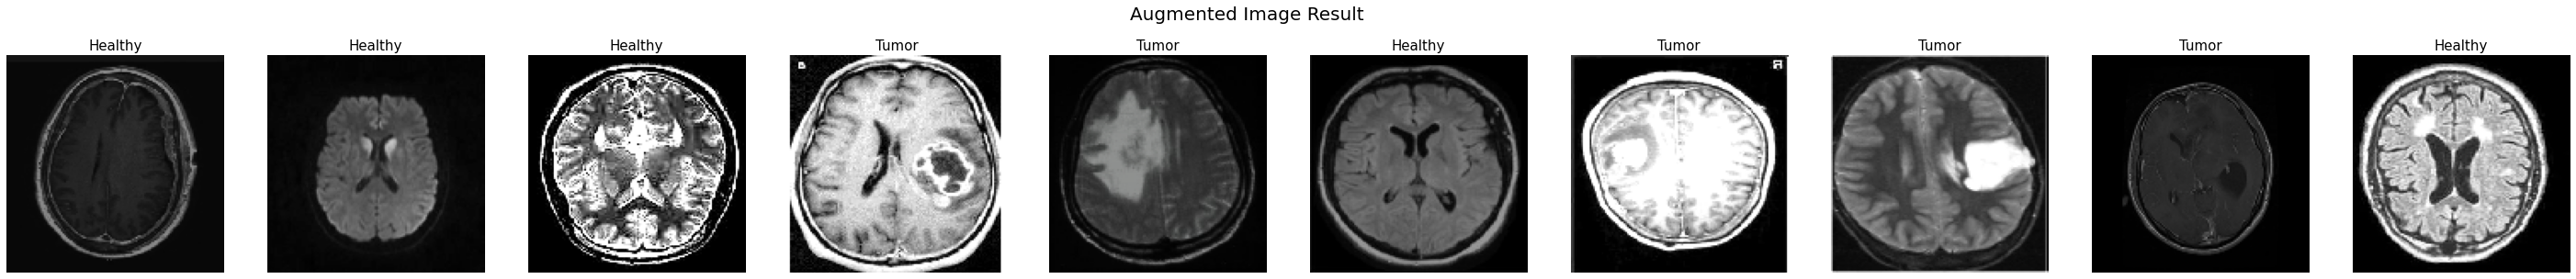

In [15]:
# Show augmented images
images, labels = next(train)

fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(50,5))
plt.suptitle('Augmented Image Result', fontsize=20)
for i in range(10):
    img = images[i]

    if labels[i] == 0:
        ax[i].set_title('Healthy', size=15)
    else:
        ax[i].set_title('Tumor', size=15)

    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_axis_off()

plt.show()

From above results, We can see the result of `Data Augmentation` that has be done to the images.\
As I said earlier, because the X-Ray images are already `black and white` color, so the augmentation to the image only limited to the images brightness only.

After this process, let's get to the model definition process.

## VI. Model Definition

In this part of process, I will define my `Simple Convolutional Neural Network` model.

Here is my `initial` model architecture:

**Method**
- I'll use `Sequential Method` to build my model architecture.

**Convolutional - Pooling layer**
- For convolutional layer, I'll utilize `Conv2D` with `32` filters, `3x3` kernel size, `padding` of `same` and `activation` of `relu`.
- I'll set the input size to 128x128x3 in accordance with my `data pipeline` settings.
- After convolutional process, I'll apply `MaxPooling2D` for my pooling layer.

**Flatten**
- Flatten is used to convert the output of the convolutional layer to a 1-D vector.

**Fully Connected Layer**
- I'll use two hidden layer with `128` and `64` neurons, with `activation` set to `relu`.

**Output Layer**
- Since our target label is `binary class`, I only need one neuron with activation set to `sigmoid`.

**Compile**
- Set optimizer to `adam`
- Set loss function to `binary_crossentropy`, due to our target label is `binary class`
- Set metrics to `accuracy`

In [16]:
# Model Definition
model = Sequential()

# Convolutional - Pool
model.add(Conv2D(filters=64, kernel_size=3, activation="relu", padding="same", input_shape=(128,128,3)))
model.add(MaxPooling2D())

# Flatten Layer
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(64, activation='relu'))

#Output layer
model.add(Dense(1, activation="sigmoid"))

# Compile Model
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])

#Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dense (Dense)               (None, 64)                16777280  
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,779,137
Trainable params: 16,779,137
Non-trainable params: 0
____________________________________________

## VII. Model Training

In this process, I will train my model so it can distinguish both the classes.\
I'll utilize `callbacks` to monitor the training process. I'll set the `monitor` to `val_loss` and `mode` to `min`, to maintain minimum value of `val_loss` of my model.

In [17]:
# Set Callbacks
callbacks = [EarlyStopping(monitor = 'val_loss',
                           mode = 'min',
                           patience = 3, 
                           restore_best_weights=True),
                           
            ModelCheckpoint('base_model.h5', 
                            monitor='val_loss', 
                            save_best_only=True)
            ]

For my initial train process, I'll start with `epochs` set to `20.`

In [18]:
#fitting model
History = model.fit(train, validation_data= val, epochs=20, 
                    verbose=1, callbacks=callbacks)

# Save history as dataframe for evaluation purpose
metrics_df = pd.DataFrame(History.history)

Epoch 1/20
12/12 [==============================] - 27s 2s/step - loss: 4.5560 - accuracy: 0.5044 - val_loss: 0.6636 - val_accuracy: 0.6481
Epoch 2/20
12/12 [==============================] - 8s 697ms/step - loss: 0.6799 - accuracy: 0.5839 - val_loss: 0.6624 - val_accuracy: 0.6399
Epoch 3/20
12/12 [==============================] - 8s 714ms/step - loss: 0.6423 - accuracy: 0.6267 - val_loss: 0.6127 - val_accuracy: 0.6359
Epoch 4/20
12/12 [==============================] - 8s 696ms/step - loss: 0.6047 - accuracy: 0.6389 - val_loss: 0.5778 - val_accuracy: 0.6576
Epoch 5/20
12/12 [==============================] - 8s 692ms/step - loss: 0.5594 - accuracy: 0.6848 - val_loss: 0.5245 - val_accuracy: 0.7418
Epoch 6/20
12/12 [==============================] - 8s 696ms/step - loss: 0.4891 - accuracy: 0.7996 - val_loss: 0.4558 - val_accuracy: 0.8220
Epoch 7/20
12/12 [==============================] - 8s 708ms/step - loss: 0.4043 - accuracy: 0.8410 - val_loss: 0.3726 - val_accuracy: 0.8601
Epoch 8/

## VIII. Model Evaluation

After training process, let's see how my model perform on the validation and test set.

**Accuracy and Loss Curves**

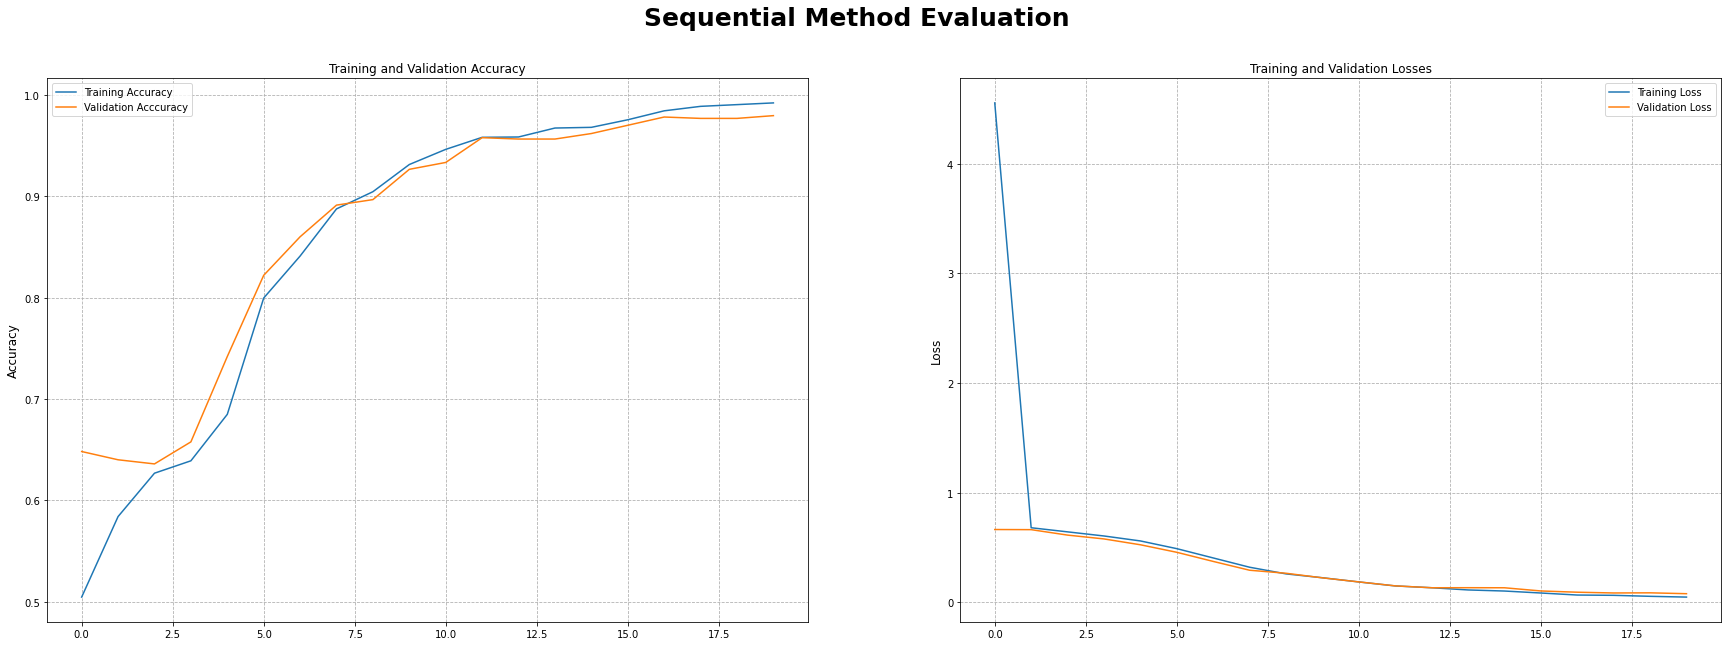

In [19]:
# Visualization
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('Sequential Method Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(metrics_df.accuracy,label="Training Accuracy")
plt.plot(metrics_df.val_accuracy, label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(metrics_df.loss, label="Training Loss")
plt.plot(metrics_df.val_loss, label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

**Accuracy Evaluation**
- Both curves (training and validation) reach accuracy above 90% level, this may a good sign that my model is working well.
- I can say that both curves moves simultaneously goes into same direction.
- Both curves first itercept at epochs = 5, but then seperate again.

**Loss Evaluation**
- Both curves (training and validation) reach loss under 2.5% level.
- Both curves first itercept at epoch around 5, but then seperate again.
- Training stopped at epoch = 14, means that there is no significant progress anymore.

Judging from both curves position, I can say that my model is `good fit.`\
Now let's see the model performance towards the test set.

**Note**

Due to neural network nature that has poor reproduceability, I'll save above graph as a figure and you can read the corresponding analysis in the `Conslusion Section.`

**Classification Report**

In [20]:
# Evaluation on test set
model.evaluate(test, verbose=1)

4/4 [==============================] - 5s 1s/step - loss: 0.1258 - accuracy: 0.9620


[0.125848650932312, 0.9619565010070801]

On the test set, My model got `96% accuracy` and `1% loss.`

In [21]:
# Classification Report
print('Classification Report - Sequential Method')
print()

pred_test = model.predict(test)
pred_test = np.where(pred_test > 0.5, 'Tumor', 'Healthy')
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred_test))

Classification Report - Sequential Method

              precision    recall  f1-score   support

     Healthy       0.96      0.95      0.96       399
       Tumor       0.96      0.97      0.97       521

    accuracy                           0.96       920
   macro avg       0.96      0.96      0.96       920
weighted avg       0.96      0.96      0.96       920



Based on classification result above, I can say that my model perform very well on predicting both classes.\
This shown by high `precision, recall, and f-1 score` for both classes.


**Model Improvement**

Actually, in my opinion my base model is already perform very good in predicting both classes. So, for my improvement process, I'll just tweak my model architechture a litle. Here is what I gonna do:
- Set 1st convolutional layer to `32` filters, `3x3` kernel size, `padding` of `same` and `activation` of `relu`. 
- Add 2nd convolutional layer with `64` filters, `3x3` kernel size, `padding` of `valid` and `activation` of `relu`.
- Add 2nd hidden layer with '32' neurons with `activation` set to `relu`.
- Set optimizer to `adamax`

**Note**

Due to neural network nature that has poor reproduceability, I'll save above graph as a figure and you can read the corresponding analysis in the `Conslusion Section.`

In [22]:
# Model Definition
imp_model = Sequential()

# 1st Convolutional - Pool
imp_model.add(Conv2D(filters=32, kernel_size=3, activation="relu", padding="same", input_shape=(128,128,3)))
imp_model.add(MaxPooling2D())

# 2nd Convolutional - Pool
imp_model.add(Conv2D(filters=64, kernel_size=3, activation="relu", padding="valid"))
imp_model.add(MaxPooling2D())

# Flatten Layer
imp_model.add(Flatten())

# Fully Connected Layer
imp_model.add(Dense(64, activation="relu"))
imp_model.add(Dense(32, activation="relu"))

#Output layer
imp_model.add(Dense(1, activation="sigmoid"))

# Compile Model
imp_model.compile(optimizer='adamax', loss="binary_crossentropy", metrics=["accuracy"])

#Summary
imp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 61504)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [23]:
# Set Callbacks
imp_callbacks = [EarlyStopping(monitor = 'val_loss',
                           mode = 'min',
                           patience = 3, 
                           restore_best_weights=True),
                           
            ModelCheckpoint('imp_model.h5', 
                            monitor='val_loss', 
                            save_best_only=True)
            ]

For the second run, I will set a higher epochs of `50.`

In [24]:
#fitting model
imp_History = imp_model.fit(train, validation_data= val, epochs=50, 
                    verbose=1, callbacks=imp_callbacks)

# Save history as dataframe for evaluation purpose
metrics_df_imp = pd.DataFrame(imp_History.history)

Epoch 1/50
12/12 [==============================] - 13s 880ms/step - loss: 0.6590 - accuracy: 0.5910 - val_loss: 0.5694 - val_accuracy: 0.6576
Epoch 2/50
12/12 [==============================] - 9s 738ms/step - loss: 0.5262 - accuracy: 0.7609 - val_loss: 0.4694 - val_accuracy: 0.8193
Epoch 3/50
12/12 [==============================] - 9s 715ms/step - loss: 0.4203 - accuracy: 0.8312 - val_loss: 0.3654 - val_accuracy: 0.8573
Epoch 4/50
12/12 [==============================] - 9s 738ms/step - loss: 0.3581 - accuracy: 0.8502 - val_loss: 0.3162 - val_accuracy: 0.8859
Epoch 5/50
12/12 [==============================] - 8s 696ms/step - loss: 0.3048 - accuracy: 0.8781 - val_loss: 0.2724 - val_accuracy: 0.8967
Epoch 6/50
12/12 [==============================] - 9s 725ms/step - loss: 0.2608 - accuracy: 0.9012 - val_loss: 0.2405 - val_accuracy: 0.9171
Epoch 7/50
12/12 [==============================] - 9s 715ms/step - loss: 0.2321 - accuracy: 0.9195 - val_loss: 0.2271 - val_accuracy: 0.9239
Epoch

**Accuracy and Loss Curves**

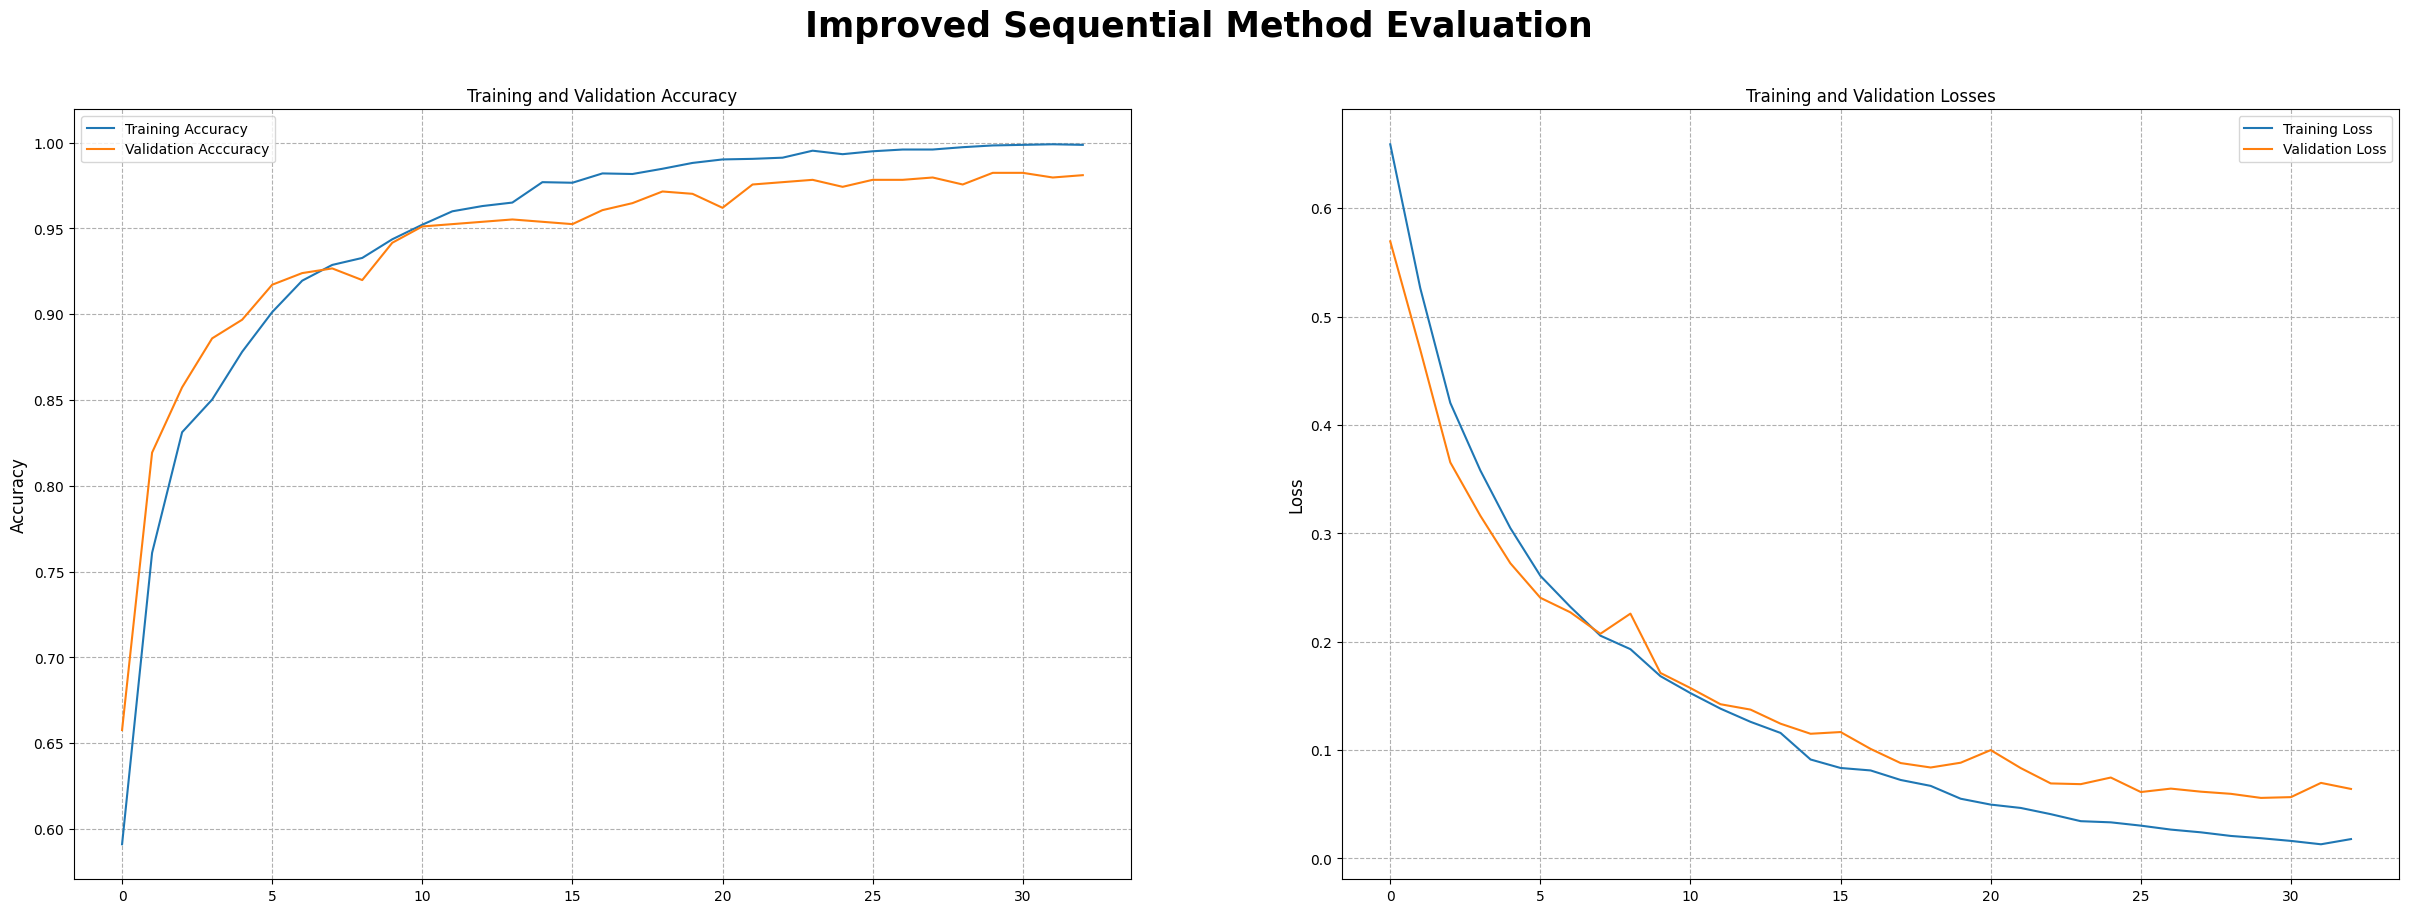

In [25]:
# Visualization
fig, ax = plt.subplots(1,2, figsize=(30,10))
fig.suptitle('Improved Sequential Method Evaluation', fontsize=25, weight='bold')

plt.subplot(1,2,1)
plt.title("Training and Validation Accuracy", fontsize=12)
plt.plot(metrics_df_imp.accuracy,label="Training Accuracy")
plt.plot(metrics_df_imp.val_accuracy, label="Validation Acccuracy")
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.subplot(1,2,2)
plt.title("Training and Validation Losses", fontsize=12)
plt.plot(metrics_df_imp.loss, label="Training Loss")
plt.plot(metrics_df_imp.val_loss, label="Validation Loss")
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(linestyle='--')

plt.style.use('default')
plt.show()

**Accuracy Evaluation**
- Both curves (training and validation) reach accuracy above 95% level, this may a good sign that this model also working well.
- I can say that both curves moves simultaneously goes into same direction.

**Loss Evaluation**
- Both curves (training and validation) reach loss under 1% level.
- I can say that both curves moves simultaneously goes into same direction.
- Training stopped at epoch = 35, means that there is no significant progress anymore.

Judging from both curves position, I can say that my model is `good fit.`\
Now let's see its performance with the test set.

**Note**

Due to neural network nature that has poor reproduceability, I'll save above graph as a figure and you can read the corresponding analysis in the `Conslusion Section.`

**Classification Report**

In [26]:
# Evaluation on test set

print('Base Model')
print(model.evaluate(test))

print('______'*15)

print('Improved Model')
print(imp_model.evaluate(test))

Base Model
4/4 [==============================] - 2s 357ms/step - loss: 0.1258 - accuracy: 0.9620
[0.125848650932312, 0.9619565010070801]
__________________________________________________________________________________________
Improved Model
4/4 [==============================] - 2s 377ms/step - loss: 0.1307 - accuracy: 0.9674
[0.13072164356708527, 0.967391312122345]


From result above, We can see that `accuracy and loss` is decreasing from base model to improved model. This indicates that improved model did not perform any better than base model.

In [27]:
# Classification Report
print('Classification Report - Sequential Method')
print()

pred_test = model.predict(test)
pred_test = np.where(pred_test > 0.5, 'Tumor', 'Healthy')
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred_test))

print('_____'*15)
print('Classification Report - Improved Sequential Method')
print()

imp_pred = imp_model.predict(test)
imp_pred = np.where(imp_pred > 0.5, 'Tumor', 'Healthy')
y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, imp_pred))

Classification Report - Sequential Method

              precision    recall  f1-score   support

     Healthy       0.96      0.95      0.96       399
       Tumor       0.96      0.97      0.97       521

    accuracy                           0.96       920
   macro avg       0.96      0.96      0.96       920
weighted avg       0.96      0.96      0.96       920

___________________________________________________________________________
Classification Report - Improved Sequential Method

              precision    recall  f1-score   support

     Healthy       0.97      0.95      0.96       399
       Tumor       0.96      0.98      0.97       521

    accuracy                           0.97       920
   macro avg       0.97      0.97      0.97       920
weighted avg       0.97      0.97      0.97       920



Based on result above, I can say that my improved model perform similarily well than my base model. This is shown by same score of `precision, recall, and f-1 score` from base model.

I can say that this project did not require any shopisticated neural network to achive better result, it is proven from process above, even with my simple base model, it could reach accuracy of 97% and my trial to improve my model has similar result.

**Note**

Due to neural network nature that has poor reproduceability, I'll save above graph as a figure and you can read the corresponding analysis in the `Conslusion Section.`

**File Size Comparisson**

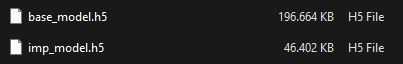

In [28]:
comp = Image.open('file_size_comp.jpg')
comp

From the file size comparisson, We can see that file size for my `improved model is one fourth of the size of my base model`. \
Because in this project I'll deploy my model on a server, `I'll need to maintain my model size`. Hence I decide to use improved model rather than the base model.\

## IX. Model Inference

In this part of process, I'll try to predict image outside the dataset. I'll use the downloaded image and image from internet as my inference set.

In [29]:
# Load saved model
model = load_model('imp_model.h5')

**From Downloaded Image**

In [30]:
# Define function to load images
def load_img(filename, img_shape=128):
  img = read_file(filename) # read image
  img = decode_image(img, channels=3) # convert to RGB
  img = resize(img, size=[img_shape, img_shape]) # resize to 128x128
  img = img/255. # Rescale to 0-1
  return img

In [31]:
# Load Inference Images
inf1 = load_img('inf1 - Normal.jpg')
inf2 = load_img('inf2 - Tumor.jpg')
inf3 = load_img('inf-Homer.jpg')
inf4 = load_img('inf3 - Tumor.jpg')
inf5 = load_img('inf4 - Normal.jpg')

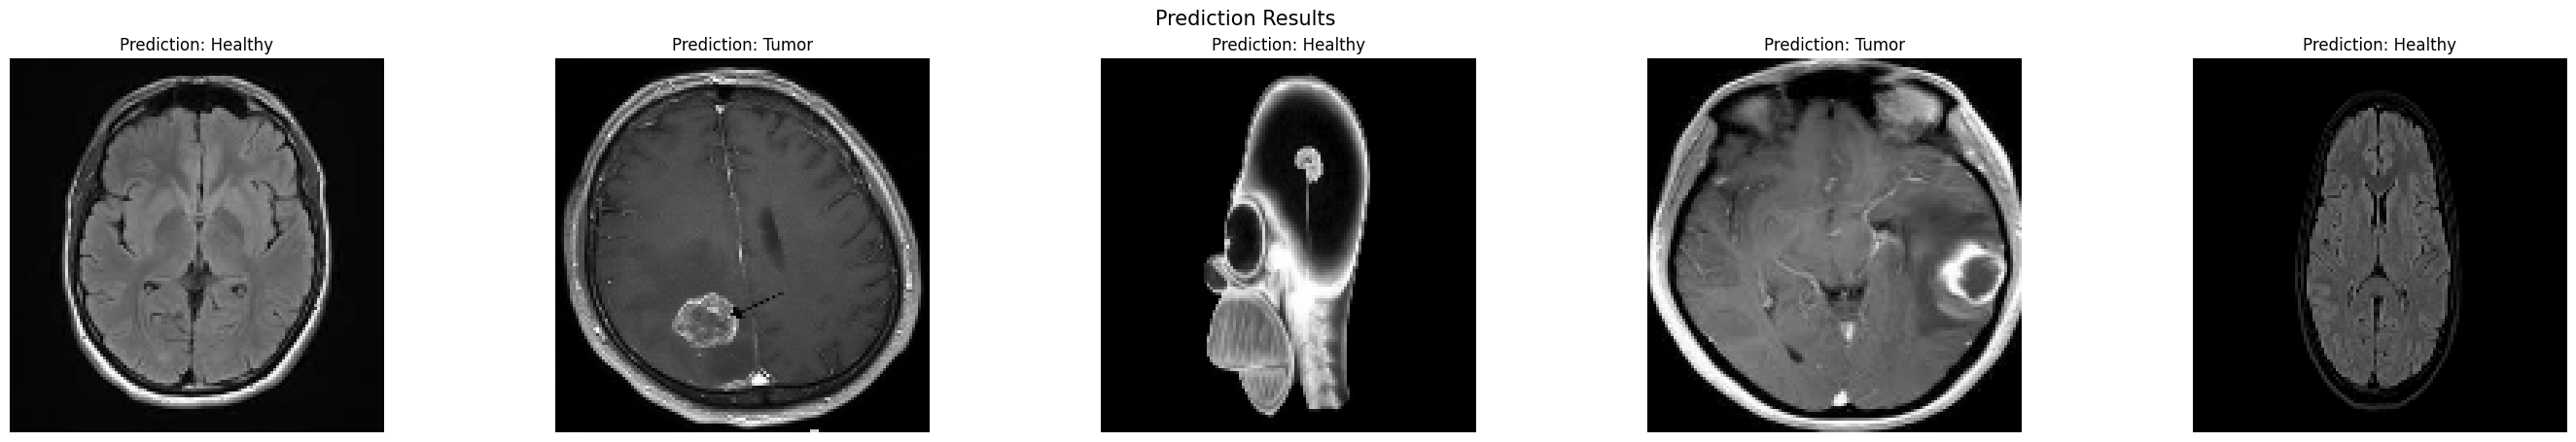

In [32]:
# Predict and show result
plt.figure(figsize=(35, 5))
plt.suptitle('Prediction Results', fontsize=15)
counter = 1
for i in [inf1, inf2, inf3, inf4, inf5]:
    plt.subplot(1, 5, counter)
    res = int(tf.round(model.predict(x=expand_dims(i, axis=0))))
    plt.imshow(i)
    plt.title(f"Prediction: {'Healthy' if res == 0 else 'Tumor'}")
    plt.axis('off')
    counter += 1
plt.show()  

**From Internet URL**

In [33]:
#  Save images URL from the net

url = [
       'https://images.theconversation.com/files/25519/original/32snfs4p-1371136880.jpg?ixlib=rb-1.1.0&rect=2%2C64%2C494%2C346&q=45&auto=format&w=926&fit=clip',
       'https://s3.amazonaws.com/static.wd7.us/3/3d/Normal-brain-MRI-003.jpg',
       'https://www.themricenterms.com/wp-content/uploads/Brain-scan-1.jpg',
       'https://content.instructables.com/ORIG/F3C/NS7P/JEIV5P36/F3CNS7PJEIV5P36.jpg?auto=webp&frame=1&fit=bounds&md=830b4164718f1f3253fcaa5de29ea130',
       'https://www.nih.gov/sites/default/files/styles/floated_media_breakpoint-large/public/news-events/research-matters/2010/20100201-braincancer.jpg?itok=xLV1oU48&timestamp=1433786578'
       ]

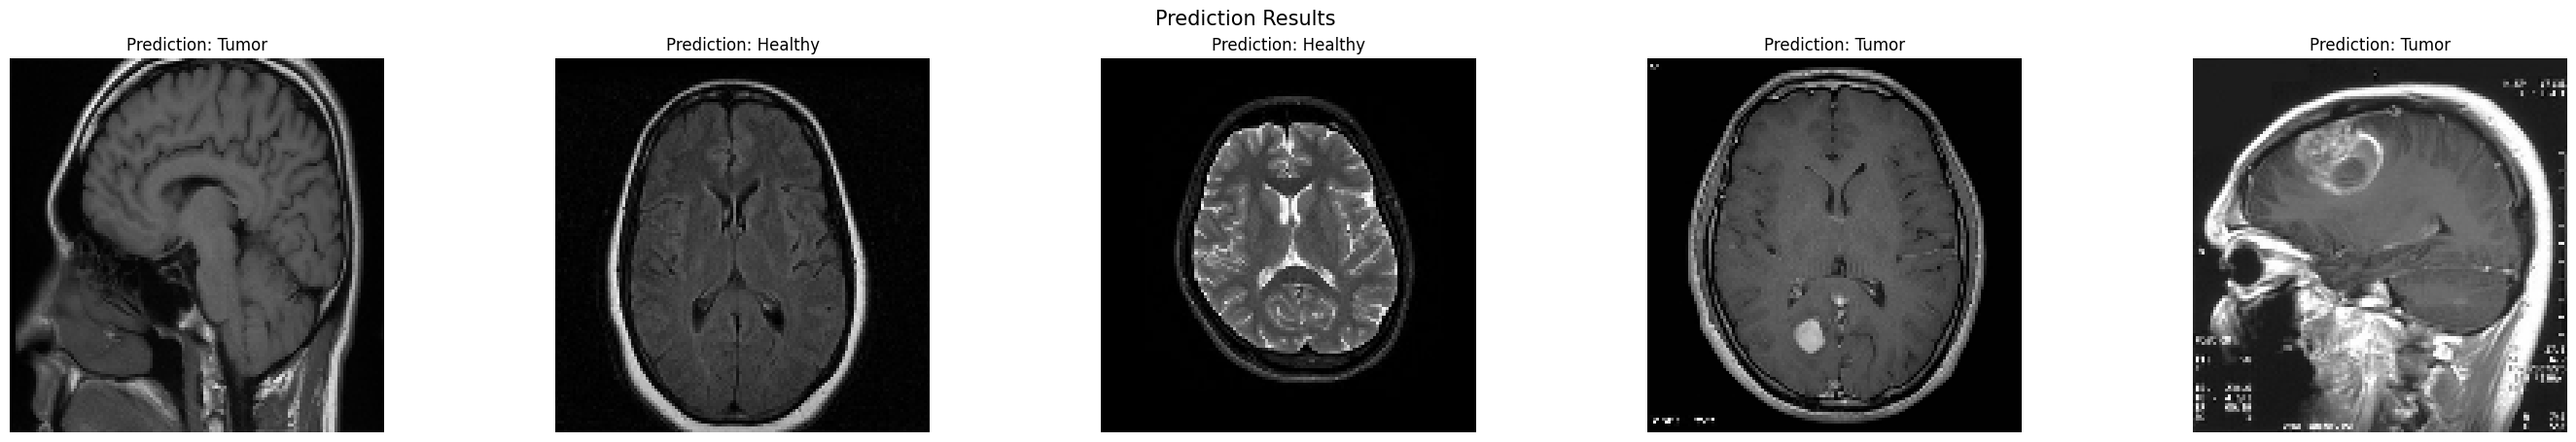

In [34]:
# Predict and show result
plt.figure(figsize=(35, 5))
plt.suptitle('Prediction Results', fontsize=15)

for i in range(len(url)):
    response = requests.get(url[i])
    img = Image.open(BytesIO(response.content))
    img = np.array(img)
    img = resize(img, size=[128, 128])
    img = img/255

    plt.subplot(1, len(url), i+1)
    plt.imshow(img)
    res = int(tf.round(model.predict(x=expand_dims(img, axis=0))))
    plt.title(f"Prediction: {'Healthy' if res == 0 else 'Tumor'}")
    plt.axis('off')
    counter += 1
plt.show()  

**Inference Conclusion**

Based on results above, I can say that my model is successfully able to distinguish between brain with `Tumor` and `Healthy` brain from given inference set.

## X. Conclusion

Here is the summary of my project.

## EDA Analysis

**Metadata Analysis**

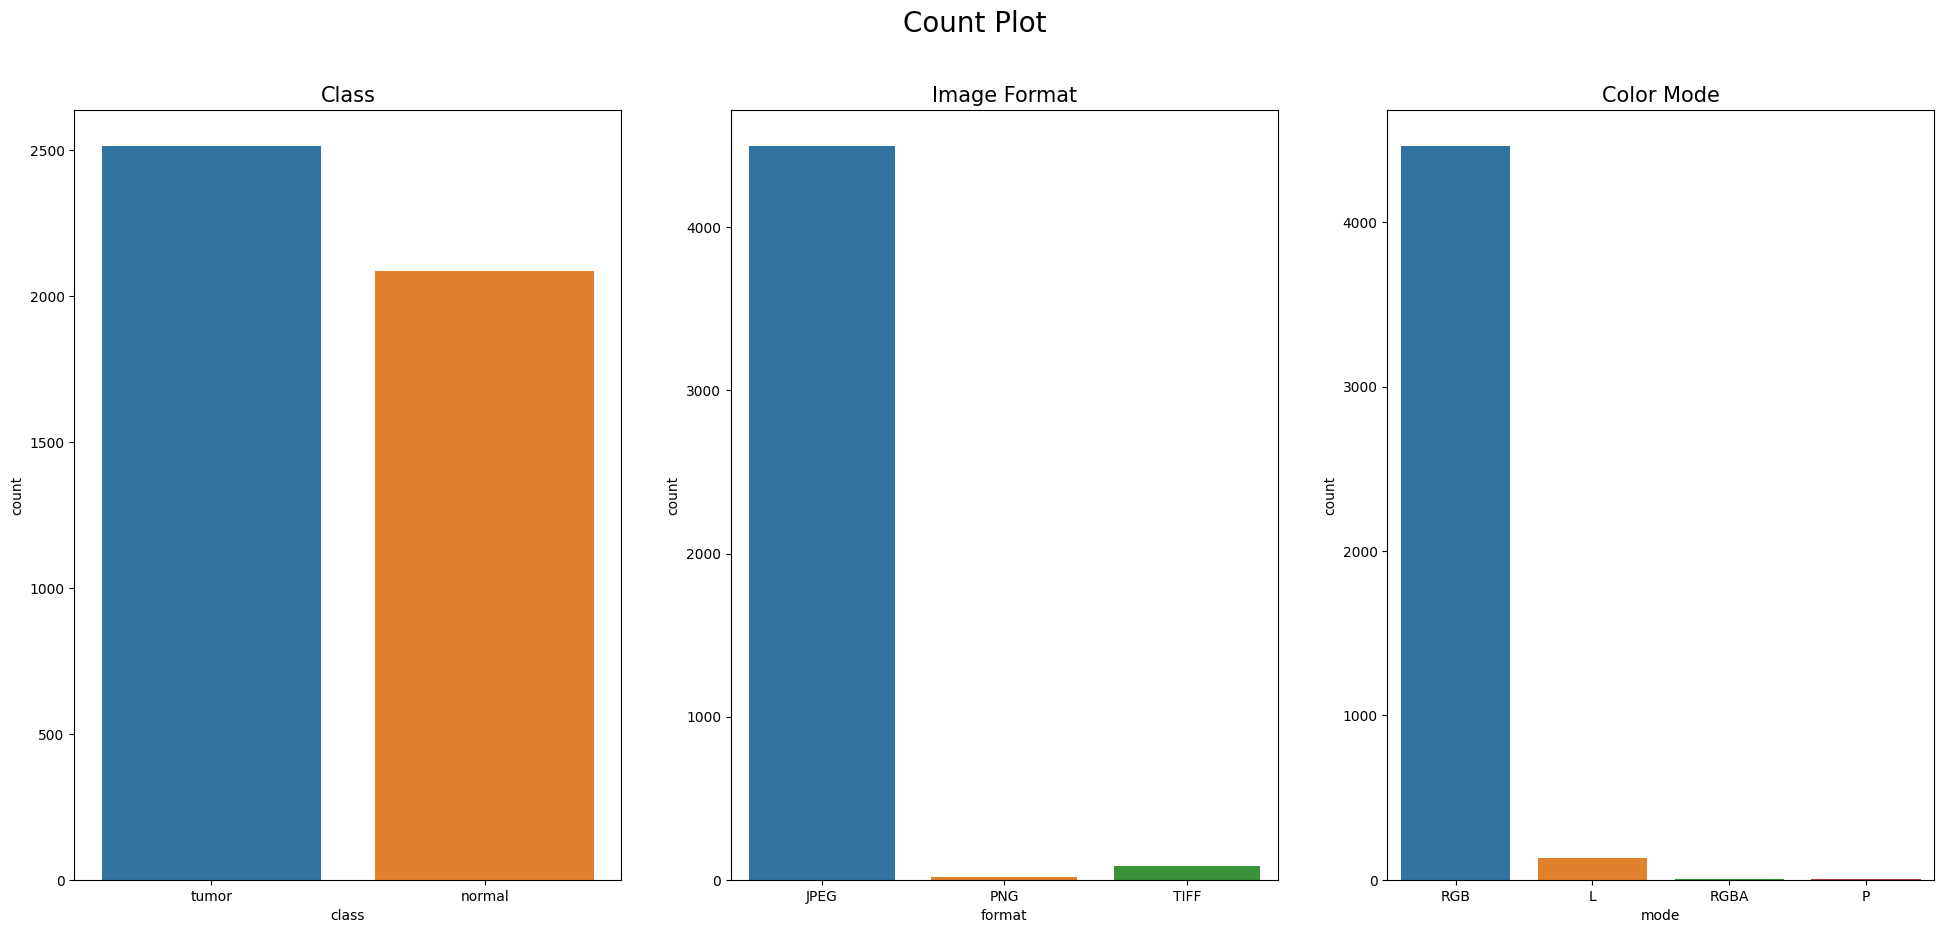

In [35]:
#  Metadata Visualization
fig, ax = plt.subplots(1,3, figsize=(24,10))
plt.suptitle('Count Plot', fontsize=20)
sns.countplot(x='class', data=metadata, ax=ax[0])
ax[0].set_title('Class', fontsize=15)

sns.countplot(x='format', data=metadata, ax=ax[1])
ax[1].set_title('Image Format', fontsize=15)

sns.countplot(x='mode', data=metadata, ax=ax[2])
ax[2].set_title('Color Mode', fontsize=15)

plt.show()

Based on process above, We can know that:
- There are 4600 images in the dataset, with 2513 instances of brain tumor and 2087 instances of normal brain. From the differences, I can tell that the instances is balanced between both class.
- There are 3 different images format in the dataset, with `4496` instances of `JPEG` format, `86` instances of `TIFF` format, and `18` instances of `PNG` format.
- There are 4 different images color mode in the dataset, with `4461` instances of `RGB` mode, `132` instances of `Cielab (L)` mode, `5` instances of `RGBA` mode, and `2` instances of `P` mode.
- The dataset consist of images with different `shape` and different `color mode`.

**Image Sample**

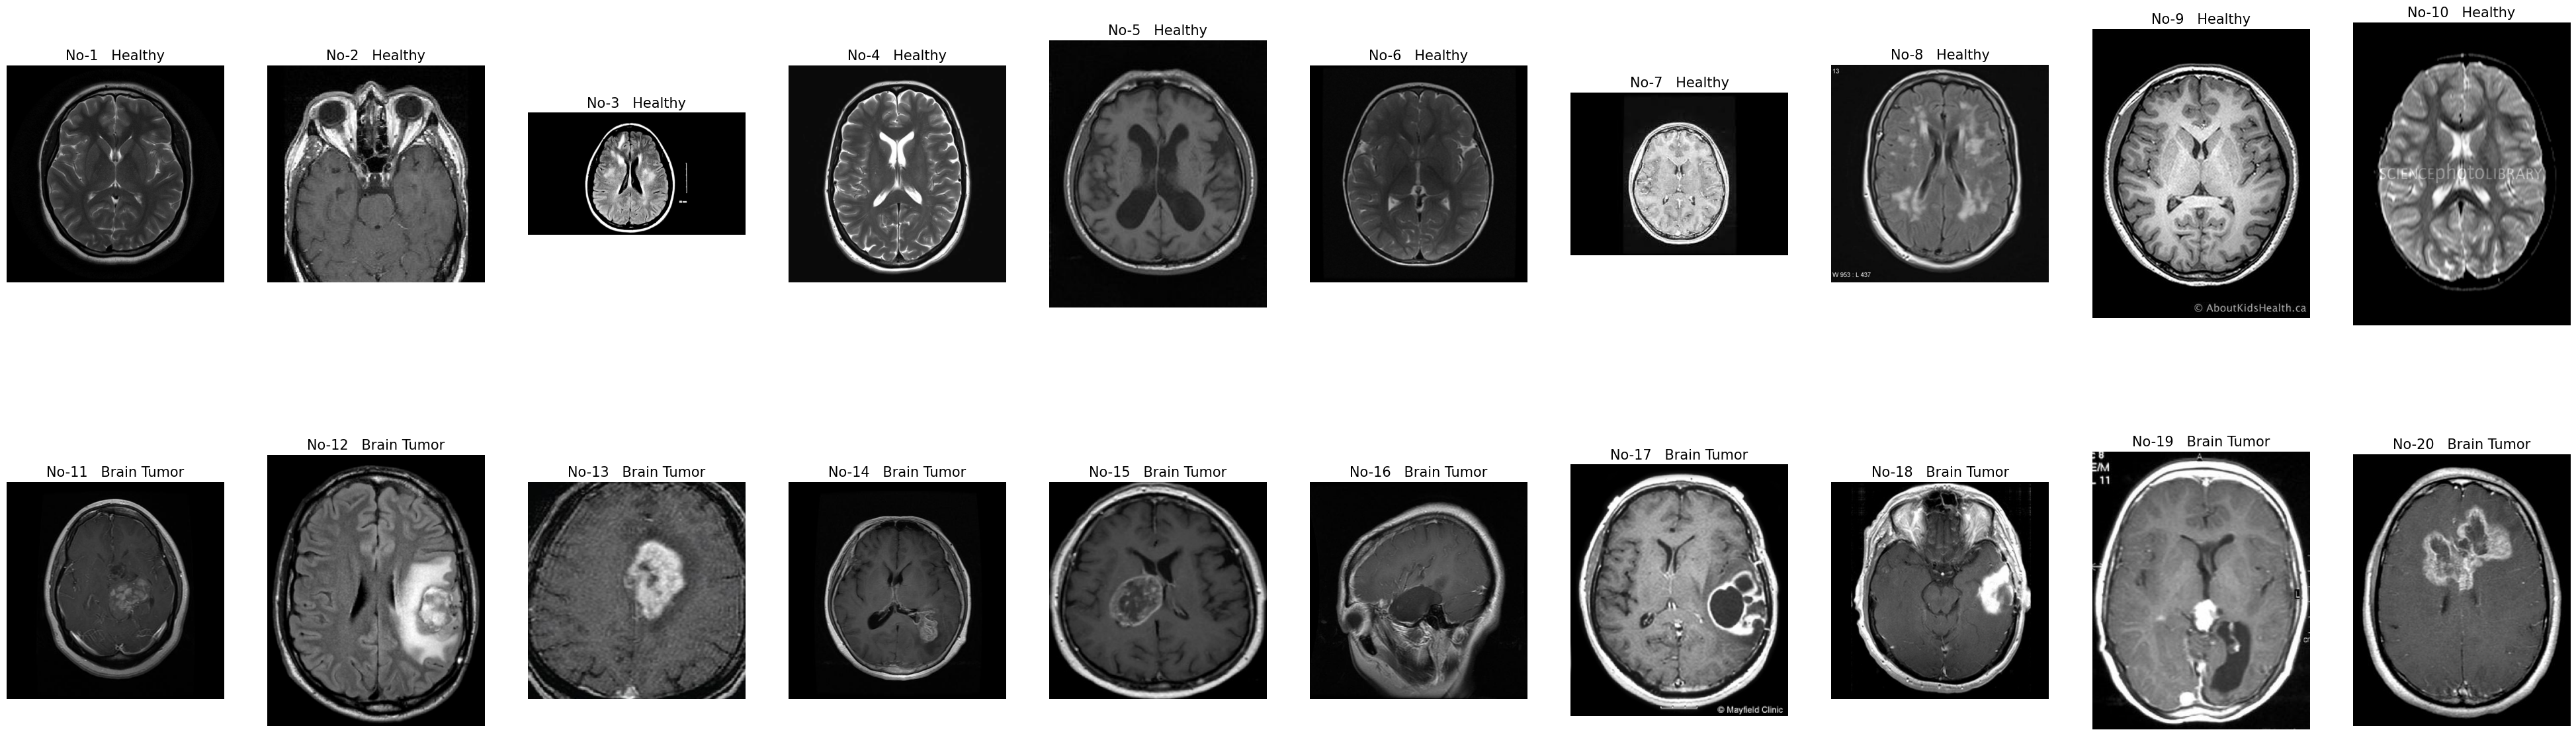

In [36]:
# Differentiate between healthy and tumor samples
healthy_samples = (main_df[main_df['labels']=="Healthy"]['filepaths'].iloc[:10]).tolist()
tumor_samples = (main_df[main_df['labels']=='Tumor']['filepaths'].iloc[:10]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=10, figsize=(50,15)) # Set figure
    for i, sample in enumerate(samples):
        img = cv2.imread(sample) # read image
        ax[i//10, i%10].set_title('No' + '-' + str(i+1)+ "   " +sample.split('\\')[-2], size=15) # set image title
        ax[i//10, i%10].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # print image
        ax[i//10, i%10].set_axis_off() # turn off axis
    plt.show() # show overall images in the figure

# Execute the function
visualize_samples(healthy_samples + tumor_samples)

- From above process, I try to show 10 images of `Healthy` human brain and 10 images of human brain with `Tumor.`
- As we can see the X-ray images has `black and white` color. From instances above, all images was taken from above, giving us clear picture of human brain. We can easily distinguish between left or right part of the brain.
- From the result, We can see that human with `Tumor` in their brain can be identified by `round-shape like` object in their brain images. Those `round-shape like` object is shown by `brighter or darker color` than other `part of the brain`.

**Augmented Image**

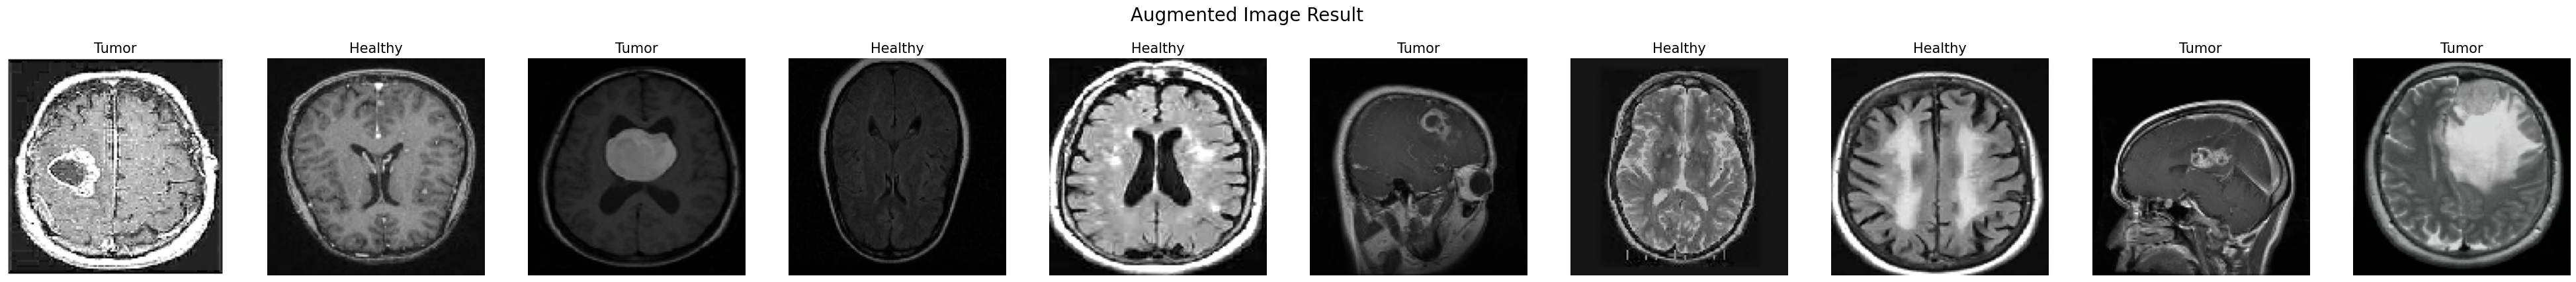

In [37]:
# Show augmented images
images, labels = next(train)

fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(50,5))
plt.suptitle('Augmented Image Result', fontsize=20)
for i in range(10):
    img = images[i]

    if labels[i] == 0:
        ax[i].set_title('Healthy', size=15)
    else:
        ax[i].set_title('Tumor', size=15)

    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i].set_axis_off()

plt.show()

For `Image Augmentation` only limited to the images brightness only.

## Model Analysis

Due to I have to deploy my model on a server, I have file size limitation. So the chosen model is `Improved Model` which perform slightly worse than my base model but has `one fourth its file size`.

### Model Architecture

Here is my final model architecture:

**Method**
- `Sequential Method`

**Convolutional - Pooling layer**
- Two convolutional - pooling layer with filters of `32` and `64`, and activation of `relu`.

**Flatten**
- Flatten is used to convert the output of the convolutional layer to a 1-D vector.

**Fully Connected Layer**
- One layer with `64` neurons and `activation` set to `relu`.

**Output Layer**
- One layer containing one node with `activation` set to `sigmoid`.

**Compile**
- Optimizer : `adam`
- Loss function : `binary_crossentropy`
- Metrics : `accuracy`

In [38]:
#Summary
imp_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 61504)             0         
                                                                 
 dense_2 (Dense)             (None, 64)               

### Model Evaluation

**Accuracy and Loss Curves**

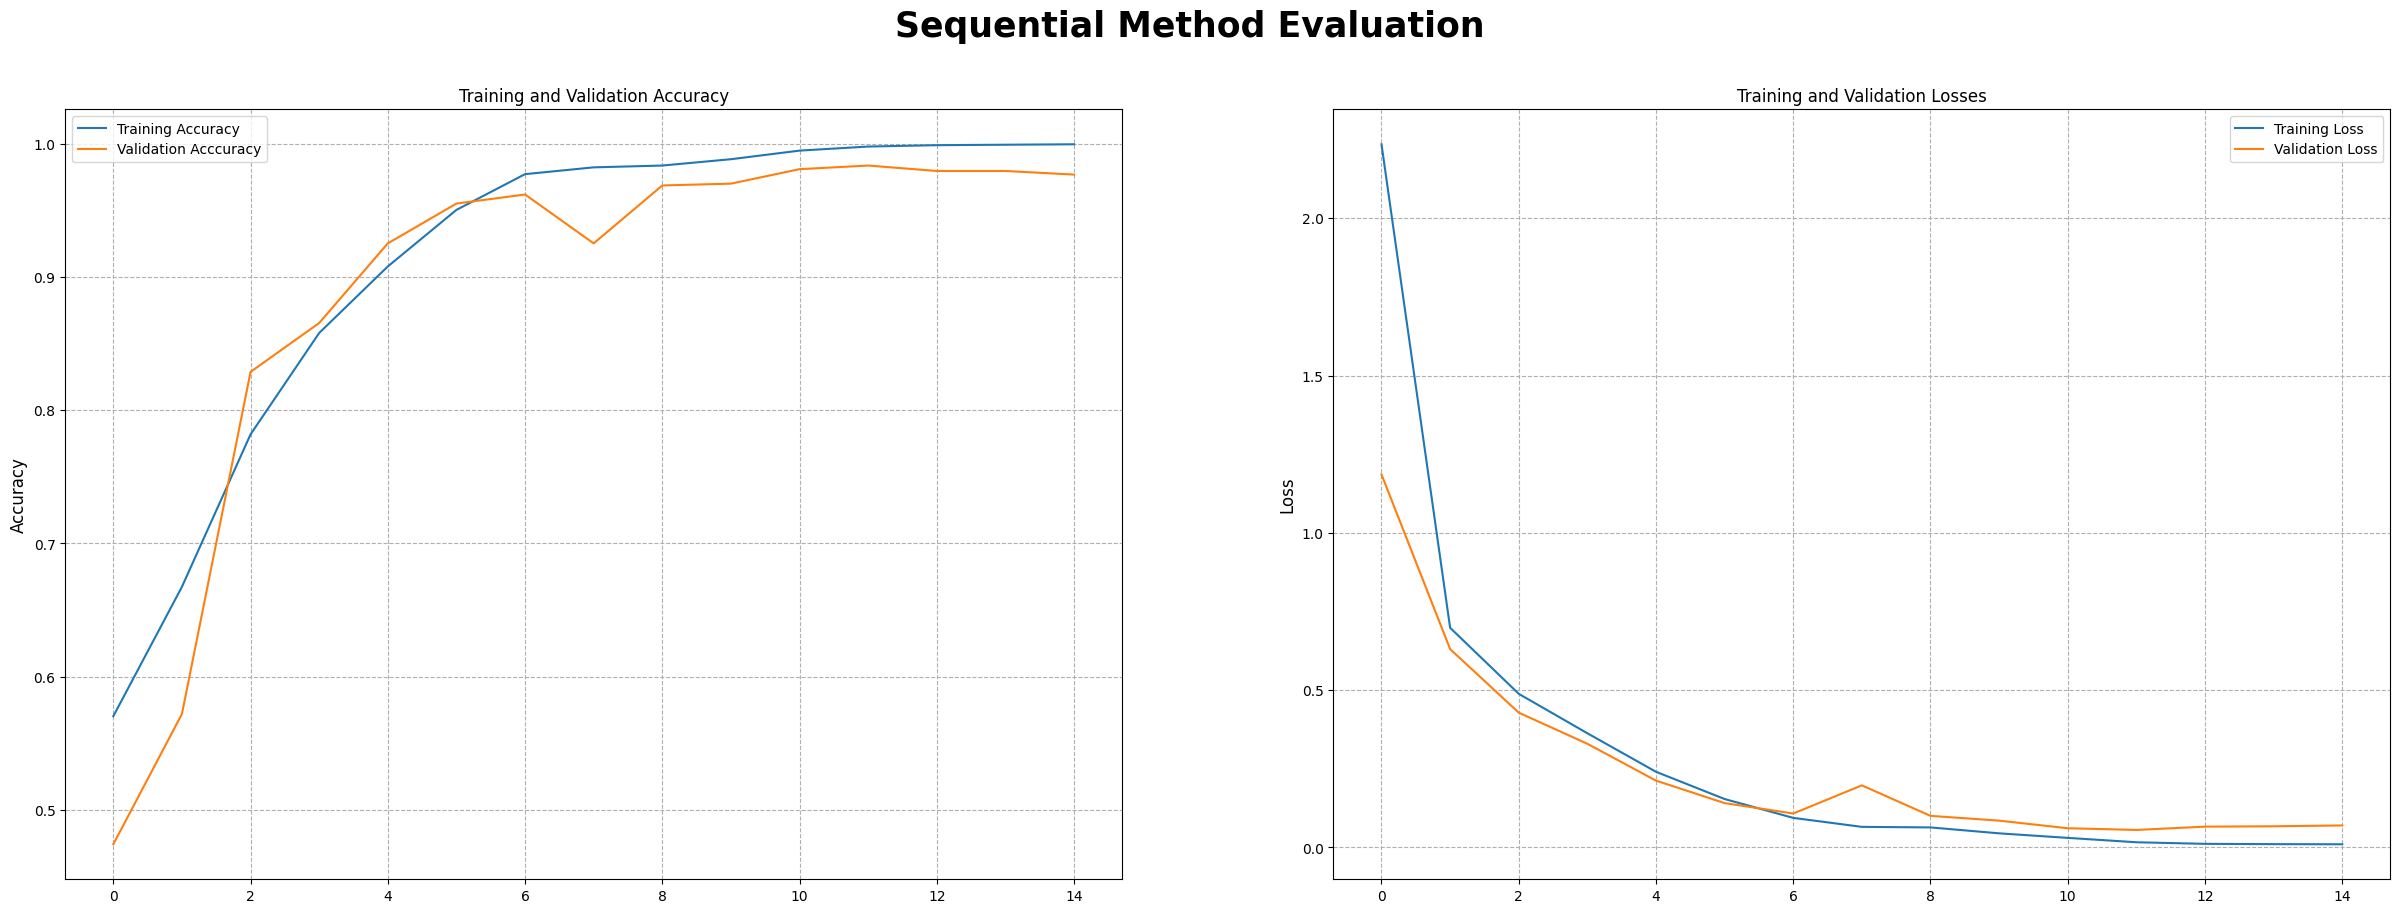

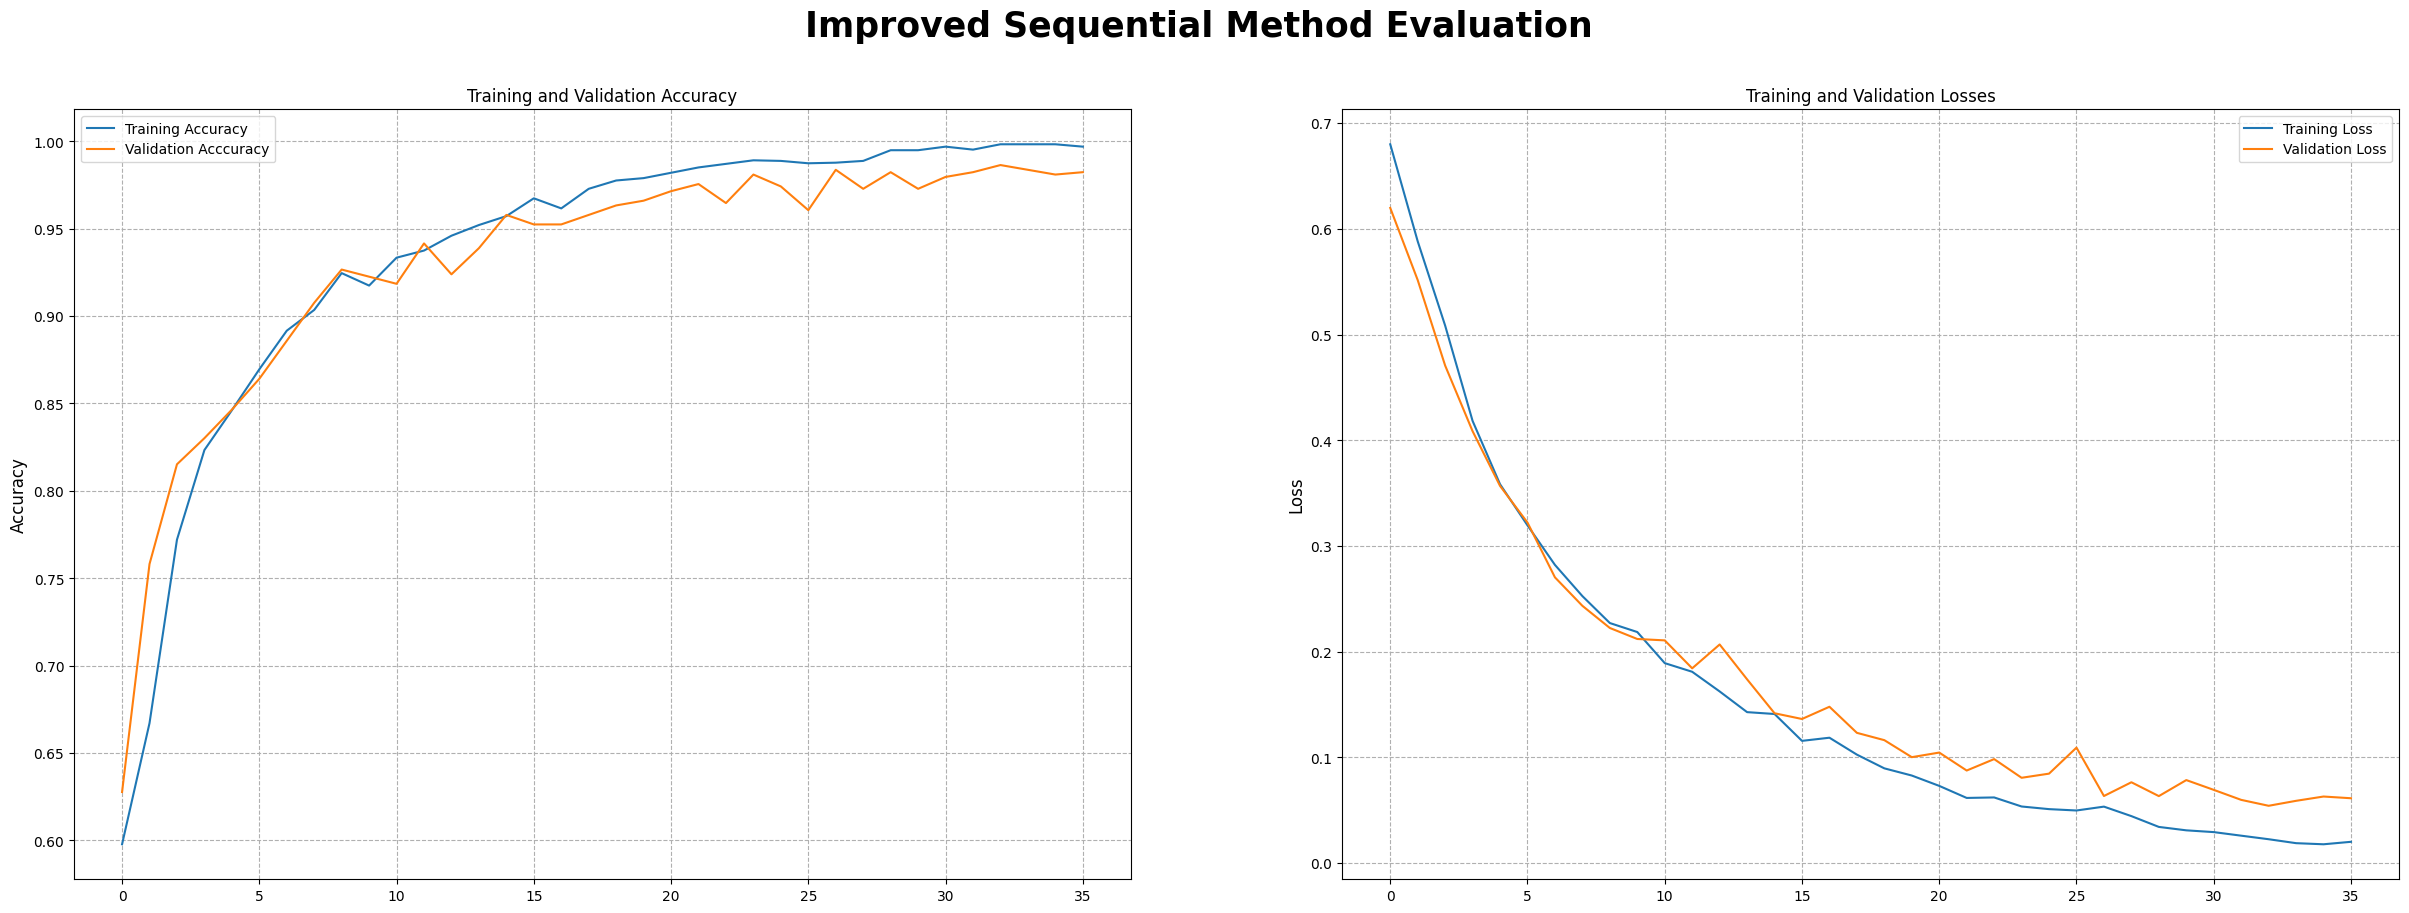

In [39]:
sequential_eval = Image.open('sequential_eval.png')
imp_sequential_eval = Image.open('imp_sequential_eval.png')

display(sequential_eval)
display(imp_sequential_eval)

**Accuracy Evaluation**
- Both curves (training and validation) reach accuracy above 95% level, this may a good sign that this model also working well.
- I can say that both curves moves simultaneously goes into same direction.

**Loss Evaluation**
- Both curves (training and validation) reach loss under 1% level.
- I can say that both curves moves simultaneously goes into same direction.

Judging from both curves position, I can say that my model is `good fit.`

There is no significant difference between my base model and my improved model.

**Classification Report**

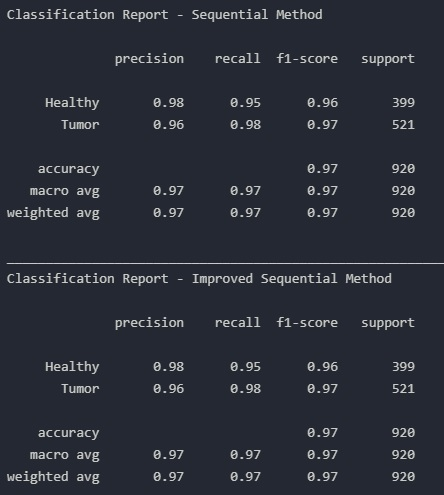

In [40]:
cr_imp_sequential = Image.open('cr_imp_sequential.jpg')
cr_imp_sequential

From classification report, I can say that there is also no significant difference between my base model and my improved model.

**File Size Comparisson**

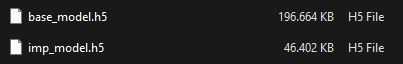

In [41]:
comp = Image.open('file_size_comp.jpg')
comp

From the file size comparisson, We can see that file size for my `improved model is one fourth of the size of my base model`. \
Because in this project I'll deploy my model on a server, `I'll need to maintain my model size`. Hence I decide to use improved model rather than the base model.\